# Advanced Skills
## 1. Downsizing data with a specific ratio
### 1) Introduction
Have you thought that given data with 5 labels, you can also do a binary classification? For example, we have 5 jets: t, q, g, w, z. Now instead of 5 Tagger, we only want to do the T Tagger, which means all the other jets are clustered to not-T. In this case, if we directly use the data, it results in input imbalance: T is only 1/4 of not-T. Thus we need to downsize the data so that elements are relatively balanced.<br><br>
Additionally, for testing, we usually use part of the data, so downsizing is very necessary.



In [3]:
import numpy as np
import h5py
import pandas as pd
from tqdm import tqdm
# TODO
# load the data "samples.h5" and find out how many constituents are labbled as "j_t".
# Hint: if a constituent belongs to t jet, the value of "j_t" should be 1, otherwise 0.
filPath = "data/samples.h5"
df = pd.read_hdf(filPath, key="data")
tJets = df[df['j_t']==1]

print("There are %d constituents of T jets." %(tJets.shape[0]))

There are 6997 constituents of T jets.


However, we cannot directly split this Series. Instead, we want to split the data by jets.

In [4]:
# TODO
# Find out the distribution of each kind of jet.
# Hint: for each jet, you only want to count it once.
labels=['j_t','j_q','j_g','j_w','j_z']
jet_dict = {}
for label in labels:
    jet_dict[label] = np.unique(df[df[label]==1]['j_index'])

Now we have a dictionary in which keys are labels and values are correpsponding jet indices.<br>
Let's take 10 for each jet.

In [5]:
# Example: randomly take 10 w jets.
jet_w = np.unique(df[df['j_w']==1]['j_index'])
chosen_jets = np.random.choice(jet_w, size = 10, replace=False) 
# Replace=False => we won't take an element more than once.
w_10 = df[df["j_index"].isin(chosen_jets)]

# TODO #1
# Create a dataframe with 10 jets for each kind.
# Hint: operate seperately and then concatenate.
jet_size = np.repeat([10],5)




# TODO #2
# Bonus: Try to create a dataset with 100 jets for total but with ratio t:q:g:z:w = 3:2:1:0:0.
# Hint: change random size.
df100 = pd.DataFrame()

for label, indices in jet_dict.items():
    chosen_jets = np.random.choice(indices,size=jet_size[labels.index(label)], replace=False)
    temp_df = df[df['j_index'].isin(chosen_jets)]
    df100 = pd.concat([df100,temp_df],axis=0)

df100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 303 to 24741
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2720 non-null   object 
 1   j_ptfrac           2720 non-null   float32
 2   j_pt               2720 non-null   float32
 3   j_eta              2720 non-null   float32
 4   j_mass             2720 non-null   float32
 5   j_tau1_b1          2720 non-null   float32
 6   j_tau2_b1          2720 non-null   float32
 7   j_tau3_b1          2720 non-null   float32
 8   j_tau1_b2          2720 non-null   float32
 9   j_tau2_b2          2720 non-null   float32
 10  j_tau3_b2          2720 non-null   float32
 11  j_tau32_b1         2720 non-null   float32
 12  j_tau32_b2         2720 non-null   float32
 13  j_zlogz            2720 non-null   float32
 14  j_c1_b0            2720 non-null   float32
 15  j_c1_b1            2720 non-null   float32
 16  j_c1_b2            27

## 2. N-Constituents of Jets
The amount of constituents varies in jets, ranging from 20 to more than 200. When we classify, we always expect to keep each jet containning the same number of constituents. For example, if we set nConstituents = 40, ranking by the transverse momentum (default), the first 40 constituents will be kept. If constituents in a jet are less than 40, we will use zero-padding.

In [6]:
# TODO
# How many constituents are in the jet with j_index=100139009?
def data_transform (nConstituents, data):
    kColumns = data.columns.shape[0]

    # we expect the output shape (mJets, nConstituents, kColumns)
    jet_list = list(set(data['j_index']))
    data_expected = []

    for jet in tqdm(jet_list):
        # Zero padding for insufficient jets. 
        # So we create a empty array and add signals in.
        jet_frame = np.zeros((nConstituents, kColumns))
        jet_temp = data[data['j_index']==jet].values
        if (jet_temp.shape[0]<nConstituents):
            for i, constituent in enumerate(jet_temp):
                jet_frame[i] = constituent
        else:
            jet_frame = jet_temp[:nConstituents] + jet_frame
        data_expected.append(jet_frame)
    # "j_index" is useless for machine learning part. Drop it!

    return np.array(data_expected)[:,:,:-1]

You are right if you got 35. But we want exact 40 slots for each jet, which means we need to do zero-padding for the last 5 slots.

In [7]:
# Example: zero-padding [0,1,2] to [0,1,2,0,0]
array = np.arange(0,3,1)

# Create an zero array with expected shape (1,5).
array_exp = np.zeros(5,dtype=int)           
# copy the corresponding elements
for i,ele in enumerate(array):
    array_exp[i] = ele

In [8]:
# Example: Slice [0,1,2,3,4,5,6,7] to [0,1,2,3,4]
array = np.arange(0,8,1)

# Create an zero array with expected shape (1,5).
array_exp = np.zeros(5,dtype=int)           
# Add the corresponding elements
array_exp = array[:5]+array_exp

Now we know how to deal with the two circumstances: nConstituents is greater or lower than the expected number. First let's try integrate it into one method.

In [10]:
# TODO
# Write a method that can fit this array into the shape (2,5).
# Hint: operate on each row and then combine them. (for loop)
array = [[0,1,2], [0,1,2,3,4,5,6,7]]
# I don't understand it has 11 elements? I can do it if it had 10
# newarr = array.flatten()
# newarr.reshape(2,5)


In [ ]:
# TODO
# In the next step we will use the method we just learned to trim our data into the desired shape.
# Hint: 1. Use "j_index" to identify jets. 
# 2. The expected output shape is in 3D: (mJets, nConstituents, kColumns), 
# so the zero array you create would be in size (nConstituents, kColumns)
# 3. loop through jets, operate one by one and then combine.

## 3. Jet Clustering & Rotating
### 1) Dependencies
You need Linux to run "pyjet". This is the tutorial to install WSL: [WSL Tutorial](https://github.com/451488975/Anaconda_Setup/blob/master/CPU_with_WSL.ipynb)

Make sure you have:
 - pyjet
<br>

### 2) Get low/high-level features
Sometimes we have data with 4-momenta form, either (e,px,py,pz) or (pT,eta,phi,mass). But we need more, such as etaRel,phiRel ...

In [50]:
# TODO
# Load and observe your data: columns, shape, datatype...
# Answer the questions:
# 1. how many jets are there?
# 2. how many constituents are in each jet?
# 3. Are all the jets are full? (no zero-paddings)
# 4. What's the datatype for each feature
# 5. What features are we gonna use to get transverse momentum, psudorapidity...
from pyjet import cluster

def _load (filePath, nJets=200000, nConstituents=40):
    '''
    Returns:
        momenta: (nJets, 4, nConstituents)
    '''
    cols = ['E_'+str(i) for i in range(nConstituents)]+ ['PX_'+str(i) for i in range(nConstituents)] + ['PX_'+str(i) for i in range(nConstituents)] + ['PY_'+str(i) for i in range(nConstituents)] + ['PZ_'+str(i) for i in range(nConstituents)] + ['is_signal_new']

    df = pd.read_hdf(filePath,key='data',stop=nJets, columns = cols)
    # Take all the 4 momentum from 200 particles in all jets and reshape them into one particle per row
    momenta = df.iloc[:,:-1].to_numpy()
    momenta = momenta.reshape(-1,nConstituents,4)
    nJets = slice(nJets)
    momenta = momenta[nJets, :nConstituents, :]
    momenta = np.transpose(momenta, (0, 2, 1))
    label = df['is_signal_new']
    return momenta, label

In [51]:
# TODO
# Load with specific shape (nJets, 4, nConstituents)
# Hint: read through the instruction of pands.read_hdf, 
# you will find a way to take just a part of rows and columns.
filePath = "data/4m_samples.h5"
nJets = 100
nConstituents = 40
momenta,labels = _load(filePath,nJets , nConstituents)

In [52]:
# I have to provide the answer for the last question, because all subsequent steps are based on this step.
def _getFeatures (momenta,nConstituents):
    # Jet features
    jetMomenta = np.sum(momenta, axis=2)
    jetPt = np.linalg.norm(jetMomenta[:, 1:3], axis=1)[..., np.newaxis]
    jetE = jetMomenta[:, 0][..., np.newaxis]
    jetP = np.linalg.norm(jetMomenta[:, 1:], axis=1)
    jetEta = 0.5 * np.log((jetP + jetMomenta[:, 3]) / (jetP - jetMomenta[:, 3]))[..., np.newaxis]
    jetPhi = np.arctan2(jetMomenta[:, 2], jetMomenta[:, 1])[..., np.newaxis]
    jetTheta = 2*np.arctan(np.exp(-jetEta))
    # Copy nConstituents times to match the shape (nJets, nConstituents).
    jetPt = np.tile(jetPt,nConstituents)
    jetE = np.tile(jetE,nConstituents)
    jetEta = np.tile(jetEta,nConstituents)
    jetPhi = np.tile(jetPhi,nConstituents)

    # Constituent features
    # delta eta, delta phi, log pT, log E,log pT / pTjet, log E / Ejet, delta R
    pT = np.linalg.norm(momenta[:, 1:3, :], axis=1)
    e = momenta[:, 0, :]
    p = np.linalg.norm(momenta[:, 1:, :], axis=1)
    mass = e**2- p**2
    # eta = 0.5 * np.log((p + momenta[:, 3, :]) / (p - momenta[:, 3, :]))
    eta = np.arcsinh(momenta[:,3,:]/pT)
    etaRel = eta - jetEta
    phi = np.arctan2(momenta[:, 2, :], momenta[:, 1, :])
    phiRel = np.unwrap(phi - jetPhi)
    dR = np.sqrt(phi ** 2 + eta ** 2)
    theta = 2*np.arctan(np.exp(-eta))
    cosThetaRel = np.cos(theta-jetTheta)
    
    # Concatenate
    # features = np.stack([jetPt, jetE, jetEta, jetPhi, pT, mass, e, eta, etaRel, phi, phiRel, dR, cosThetaRel],axis=-1)
    features = np.stack([pT,eta,phi,mass, etaRel, phiRel, e, dR, cosThetaRel, jetPt, jetE, jetEta, jetPhi],axis=-1)
    return features

In [53]:
# TODO
# get low level features: pT, eta, phi, ... 
# Try to get as many feature as possible, the answer will be probided after camp.
# Hint: reference page (https://www.lhc-closer.es/taking_a_closer_look_at_lhc/0.momentum)
features = _getFeatures(momenta,nConstituents)


<ipython-input-52-8152dea33b9c>:24: RuntimeWarning: invalid value encountered in true_divide
  eta = np.arcsinh(momenta[:,3,:]/pT)


### 3) Cluster and Rotate
Rotation is performed to remove the stochastic nature of the decay angle relative to the η − φ coordinate system. For two-body decay processes (such as the hadronic decay of a W boson) the direction connecting the axes of the leading two subjets can be rotated until the leading subject is directly above the subleading subjet.
<br><br>
More information about Jet-Image: [Paper](https://arxiv.org/pdf/1407.5675.pdf)

In [55]:
# Example: Clustering
# For each event(jet), we cluster it to get subjets.
# Assuming you already have one piece of jet called "event".
# Unfortunately, it is not runable, due to the undefined parameter "event",
# but if you complete the get features part, at least you have 'pT, eta, phi, mass', 
# you can load your results to run this code.
# Notice that event is one jet, and features should follow the order 'pT, eta, phi, mass'.
from pyjet import cluster
flattened_event = np.core.records.fromarrays( [event[:,0],event[:,1],event[:,2],event[:,3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')
sequence = cluster(flattened_event, R=R0, p= p)
jets = sequence.inclusive_jets()

If you get error about pyjet, please check wheter you are using Linux system. WSL is recommmened.

In [46]:
# TODO
# Try clustering one piece of jet from your results.
features = getRot(features,R0=0.2,p=-1)

100%|██████████| 100/100 [00:00<00:00, 5408.79it/s]


Now we have the four features of subjets. We want to put the leading subjet at the origin, and the subleading subjet at -pi/2


In [44]:
# Example: Rotation
# shifts all data with respect to the leading subjet so that
# the Jet Image is centerd at the origin (eta,phi) = (0,0).
def deltaPhi(phi1,phi2):
    # Make sure it in the range (-pi, pi)
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

eta -= jets[0].eta
phi = np.array( [deltaPhi(i,jets[0].phi) for i in phi])

# Rotate the jet image such that the second leading
# subjet is located at -pi/2
s1x, s1y = jets[1].eta -jets[0].eta, deltaPhi(jets[1].phi,jets[0].phi)

theta = np.arctan2(s1y, s1x)
if theta < 0.0:
    theta += 2 * np.pi
def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp
etaRot, phiRot = rotate(eta, phi, np.pi - theta)

NameError: name 'eta' is not defined

In [43]:
# TODO
# Try to cluster and rotate every jet to get etaRot and phiRot.
def _clusterAndRotate (event, R0, ep=False, p=-1):
    '''
    R: Clustering radius for the main jets
    p = -1, 0, 1 => anti-kt, C/A, kt Algorithm
    ep = False, True => (px,py,pz,e) , (pT,eta,phi,mass)
    '''
    flattened_event = np.core.records.fromarrays( [event[:,0],event[:,1],event[:,2],event[:,3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')
    sequence = cluster(flattened_event, R=R0, p= p)
    jets = sequence.inclusive_jets()

    if len(jets)<2:
        return []
    else:
        subjet_data = event
        subjet_array = jets

    pT = subjet_data[:, 0]
    eta = subjet_data[:, 1]
    phi = subjet_data[:, 2]
    mass = subjet_data[:, 3]

    # shifts all data with respect to the leading subjet so that
    # the Jet Image is centerd at the origin (eta,phi) = (0,0).
    eta -= subjet_array[0].eta
    phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])

    # Rotate the jet image such that the second leading
    # subjet is located at -pi/2
    s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)

    theta = np.arctan2(s1y, s1x)
    if theta < 0.0:
        theta += 2 * np.pi
    etaRot, phiRot = rotate(eta, phi, np.pi - theta)
    
    return etaRot, phiRot

def getRot (features,R0,p=-1,ep=False):
    etaRot = []
    phiRot = []
    for i in tqdm(range(features.shape[0])):
        event = features[i,:,:4]
        eta_R,phi_R = _clusterAndRotate(event,R0)
        etaRot.append(eta_R)
        phiRot.append(phi_R)

    features = np.append(features,np.expand_dims(etaRot,axis=2),axis=2)
    features = np.append(features,np.expand_dims(phiRot,axis=2),axis=2)
    return features

features = getRot(features,R0=0.2,p=-1)

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'rotate' is not defined

### 4) Visualization
Let's review how to plot Jet Image.<br>
In this case, we are provided with data with zero-paddings. We need to eliminate them before ploting, since zeros would lead to nan for eta and phi.

In [47]:
# TODO
# Find out the indices where pT=0 from the features you get previously.
# Hint: np.where()
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
def getImage (features,R=1.2,bins=64):
    validIndices = np.where(features[:,:,0]!=0)
    etaRot = features[validIndices[0],validIndices[1],-2]
    phiRot = features[validIndices[0],validIndices[1],-1]
    pT = features[validIndices[0],validIndices[1],0]

    ranges = np.array([[-R,R],[-R,R]])

    # Sum energy deposits in each bin
    digitized = binned_statistic_2d(etaRot, phiRot, pT, statistic="sum", bins=bins, range= ranges)
    jet_image = digitized.statistic
    # Reverse the y axis, because it originally points downward.
    jet_image = jet_image[::-1,:]

    return jet_image

def plotImage (jet_image):
    # Take log to zoom in.
    plt.imshow(np.log(jet_image), extent = [-1.2,1.2,-1.2,1.2], cmap = 'Blues')

<ipython-input-47-4c000deacda1>:24: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(jet_image), extent = [-1.2,1.2,-1.2,1.2], cmap = 'Blues')


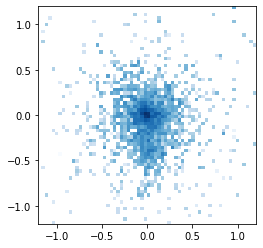

In [48]:
# TODO
# get all the non-zero (etaRot,phiRot,pT) set using conditional slicing.
# And then plot a 2D-histogram.
jet_image = getImage(features)
plotImage(jet_image)